In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
cd drive/MyDrive/Advanced-Deep_Neural/

/content/drive/MyDrive/Advanced-Deep_Neural


**Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

from tensorflow import keras
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor

import torchvision
import torchvision.transforms as transforms
import os
import seaborn as sns
from tqdm.notebook import tqdm
%matplotlib inline

**Dataset**

The dataset is a distilled subset of the Planet: Amazon sattelite dataset competition in 2017. The dataset includes small squares of satellite images taken from space of the Amazon rainforest in Brazil in terms of 17 classes. This subset was selected to reduce computation time of the full dataset that comprises 40,779 images were provided in the training dataset and 40,669 images. The subset includes a total of 40.479 distilled by a user in Kaggle.
The color images were provided JPEG format with the size 256×256 pixels.
The link to the source images is this https://www.kaggle.com/datasets/normancodes/planet-amazon-consolidated


First, I import the dataset from Kaggle. The user made it available to connect online. The code to extract the data was adapted from this notebook https://www.kaggle.com/code/normancodes/training-baseline-cnn

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("normancodes/planet-amazon-consolidated")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/planet-amazon-consolidated


In [4]:
PLANET_KAGGLE_ROOT = os.path.abspath("/root/.cache/kagglehub/datasets/normancodes/planet-amazon-consolidated/versions/6")
PLANET_KAGGLE_JPEG_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'images')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, 'labels.csv')
assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)

**Labels processing**

Each image has one or more class labels.The labels can broadly be broken into three groups: atmospheric conditions, common land cover/land use phenomena, and rare land cover/land use phenomena.

The original dataset mentions this main labels. https://www.kaggle.com/competitions/planet-understanding-the-amazon-from-space/data

![Chips Image](https://storage.googleapis.com/kaggle-media/competitions/kaggle/6322/media/chips.jpg)







In [5]:
labels_df = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)
labels_df.head()

,image_name,tags
0,image_0,haze primary
1,image_1,agriculture clear primary water
2,image_2,clear primary
3,image_3,clear primary
4,image_4,agriculture clear habitation primary road


In [6]:
labels_df.tags.value_counts()

,count
tags,
clear primary,13636
partly_cloudy primary,3630
cloudy,2089
clear primary water,1850
agriculture clear primary road,1680
...,...
agriculture artisinal_mine clear cultivation primary,1
agriculture artisinal_mine clear cultivation primary road water,1
agriculture clear cultivation cultivation habitation primary water,1


The tags will be separated by space and then dropping duplicates values to have only a a set of unique tags that will be assigned a number that will be the classes in which the model will be trained. To deal with the noise of the tags the below code was adapted from https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-satellite-photos-of-the-amazon-rainforest/

In [7]:
# the set of labels
labels = set()
for i in range(len(labels_df)):
	# convert spaced separated tags into an array of tags
	tags = labels_df['tags'][i].split(' ')
	# add tags to the set of known labels
	labels.update(tags)

In [8]:
# Label map with the labels assigned a number and the inverse for plotting purposes
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

In [9]:
inv_label_map

{0: 'water',
 1: 'agriculture',
 2: 'blow_down',
 3: 'primary',
 4: 'slash_burn',
 5: 'clear',
 6: 'habitation',
 7: 'artisinal_mine',
 8: 'haze',
 9: 'road',
 10: 'conventional_mine',
 11: 'cultivation',
 12: 'cloudy',
 13: 'bare_ground',
 14: 'blooming',
 15: 'selective_logging',
 16: 'partly_cloudy'}

**Torch dataset**

To create a torch dataset, the code from the seminars was adapted.

In [10]:
from torchvision.io import read_image
from torch.utils.data import Dataset
import cv2
class PlanetAmazonDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.label_map = {l: i for i, l in enumerate(list(set([tag for tags in self.img_labels['tags'] for tag in tags.split()])))}  # Label encoding

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name = self.img_labels.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, f"{img_name}.jpg")

        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        labels = self.img_labels.iloc[idx, 1].split()
        label_tensor = torch.zeros(len(self.label_map))  # Initialize a zero tensor for multi-label classification
        for label in labels:
            label_tensor[self.label_map[label]] = 1  # Set corresponding indices to 1
        if self.transform:
            image = self.transform(image)

        return image, label_tensor


From the seminars the two transform functions were used. The first one to crops the image while the second one, for inversing the transformation for plotting purposes.

In [11]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization
])

In [12]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

In [13]:
dataset = PlanetAmazonDataset(PLANET_KAGGLE_LABEL_CSV, PLANET_KAGGLE_JPEG_DIR, transform=transform)

# to check the size of the dataset
print(f"Dataset size: {len(dataset)} images")

# Retrieve a sample
img_sample, label_sample = dataset[0]
print(f"Sample image shape: {img_sample.shape}")
print(f"Sample labels: {label_sample}")  # Multi-hot encoded labels

Dataset size: 40479 images
Sample image shape: torch.Size([3, 224, 224])
Sample labels: tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])


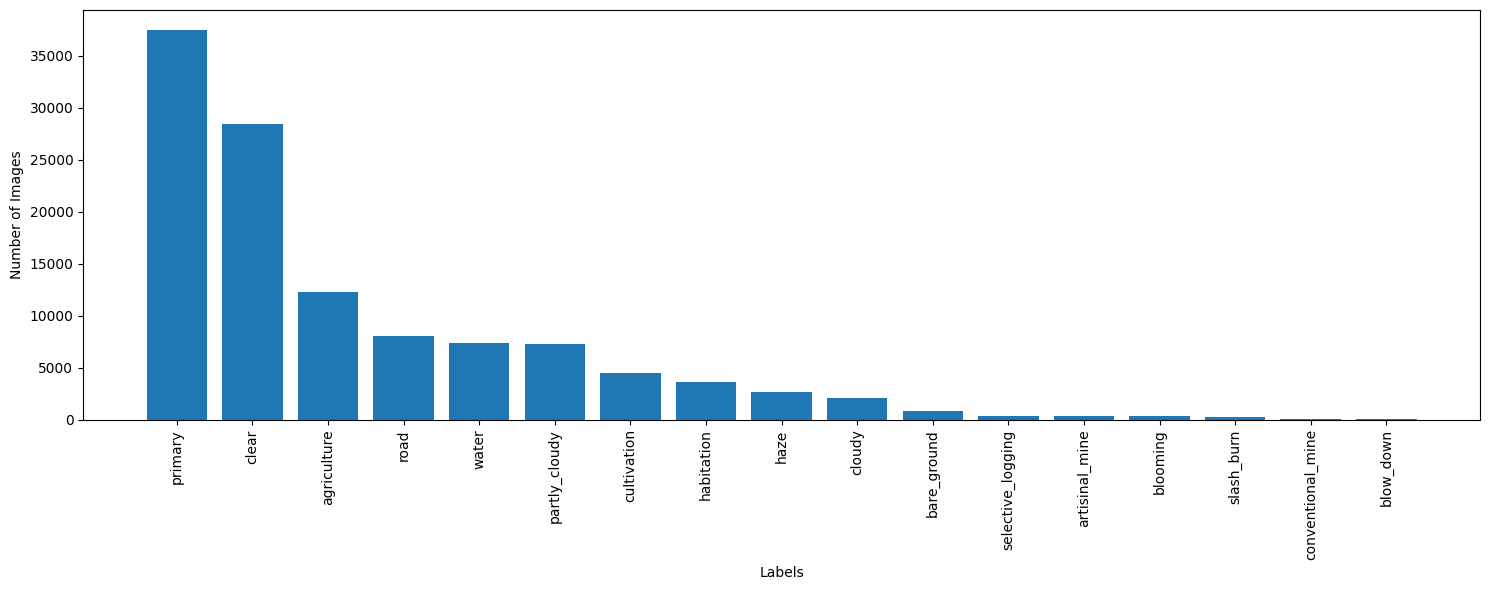

In [14]:
# Histogram of the frequency of images in each label
label_counts = {}
for _, labels in dataset:
    for i in range(len(labels)):
        if labels[i] == 1:
            label_name = inv_label_map[i]
            label_counts[label_name] = label_counts.get(label_name, 0) + 1

# For aesthetic purposes, to sort the values from highest to lowest
sorted_label_counts = dict(sorted(label_counts.items(), key=lambda item: item[1], reverse=True))

# Plot
plt.figure(figsize=(15, 6))
plt.bar(sorted_label_counts.keys(), sorted_label_counts.values())  # Use sorted dictionary
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel("Labels")
plt.ylabel("Number of Images")
plt.tight_layout()
#plt.savefig('Histogram.png')
plt.show()

In [15]:
from torch.utils.data import DataLoader
dataset_dataloader = DataLoader(dataset, batch_size=24, shuffle=True)

For plotting a subset of the images, I use the function of the seminars adapted with code to display the labels.

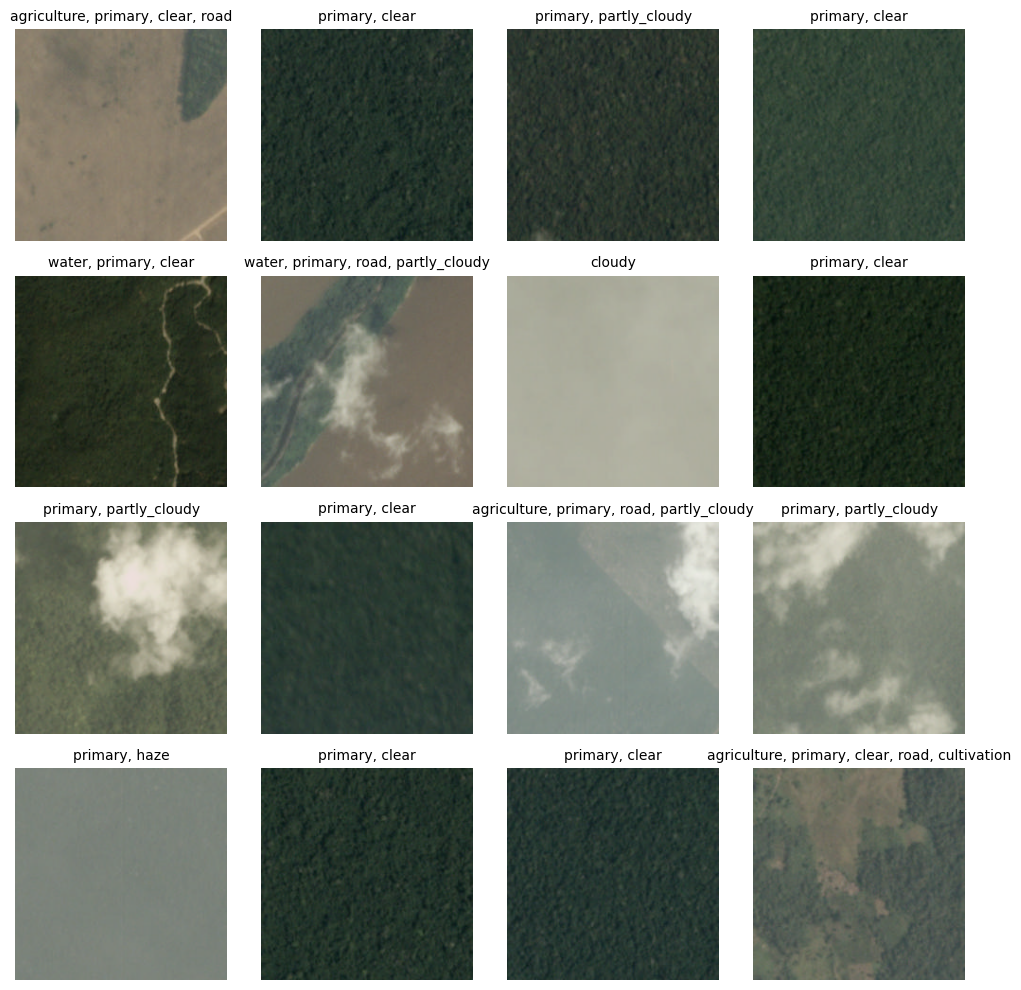

In [16]:
dataiter = iter(dataset_dataloader) # to get some random training images
images, labels = next(dataiter)

# To limit to 16 images
images = images[:16]
labels = labels[:16]

# Undo normalization for display
inv_images = inv_normalize(images)

# Decoding multi-labels to words for better interpretation (I use gemini AI for this. The prompt was "how to display the labels in words instead of the vector encoding?")
batch_word_labels = []
for label_tensor in labels:
    indices = (label_tensor == 1).nonzero(as_tuple=True)[0]
    tags = [inv_label_map[i.item()] for i in indices]
    batch_word_labels.append(", ".join(tags))
#Plot
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = inv_images[i].numpy()
    img = np.transpose(img, (1, 2, 0))
    ax.imshow(img)
    ax.set_title(batch_word_labels[i], fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.savefig('Images_subset.png')
plt.show()

**Pre-trained model**

This report uses a pre-trained set of parameters.
ResNet50 is a deep convolutional neural network architecture that was developed by Microsoft Research in 2015 and stands for “Residual Network.” The version to use in this study consist in  50 layers.

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The code was adapted from the seminars. In this case, it was adapted to use Resnet.

In [18]:
import torch.nn as nn
from torchvision import models

num_classes = 17
feature_extract = True
use_pretrained = True

def set_parameter_requires_grad(model, feature_extracting):
    """Freeze model layers if feature_extracting is True."""
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

#Rretrained ResNet-50 model
model_ft = models.resnet50(pretrained=use_pretrained)
set_parameter_requires_grad(model_ft, feature_extract)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
model_ft = model_ft.to(device)

**Train/test split**

In [20]:
from torch.utils.data import random_split
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size]) #As seen in the previous term, in intro
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=24, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=24, shuffle=False)

**Accuracy metrics**

The accuracy score and F2 score used were adapted from the Kaggle competition due to the nature of the task to be multi-label. In order to better comparison with the models used in the competition, these scores were used. The code was adapted from:
https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-satellite-photos-of-the-amazon-rainforest/

In [21]:
def accuracy_score(y_true, y_pred, threshold=0.5): #a threshold of 50% that means if a image has more than 50% probabilities to contain the label
    y_pred = (y_pred > threshold).float() #if the probability of the prediction is greater than the threshold then it turns into 1
    correct = (y_pred == y_true).float().sum() #usm of the labels predicted that match the ground truth
    total = torch.numel(y_true) #number of true labels
    return correct / total

In [22]:
def fbeta(y_true, y_pred, threshold_shift=0.0, beta=2.0, epsilon=1e-9): #f2score
    y_pred = torch.clamp(y_pred, 0, 1).float()
    y_pred_bin = torch.round(y_pred + threshold_shift).float()  # threshold and binarize predictions
    y_true = y_true.float()

    # Count true positives, false positives, and false negatives
    tp = torch.sum(torch.round(y_true * y_pred_bin)) + epsilon
    fp = torch.sum(torch.round(torch.clamp(y_pred_bin - y_true, min=0)))
    fn = torch.sum(torch.round(torch.clamp(y_true - y_pred_bin, min=0)))

    # Calculate precision and recall
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)

    beta_squared = beta ** 2
    fbeta_score = (1 + beta_squared) * (precision * recall) / (beta_squared * precision + recall + epsilon)

    return fbeta_score.item()


**Train/Test loop**
As seen on the seminars, two functions were created. One, to train the model on the train set and collect the accuracy metrics (loss, F2_score, accuracy). The other set, to apply the trained function on the test set and collect the accuracy metrics.

In [23]:
# Train loop
def train_loop(dataloader, model, loss_fn, optimizer, device):
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss, total_acc, total_f2 = 0, 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)

        acc = accuracy_score(y, pred)
        f2 = fbeta(y, pred)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += acc.item()
        total_f2 += f2

    avg_loss = total_loss / num_batches
    avg_acc = total_acc / num_batches
    avg_f2 = total_f2 / num_batches

    print(f"Train: Accuracy: {avg_acc*100:.2f}%, F2 Score: {avg_f2:.4f}, Avg Loss: {avg_loss:.4f}")
    train_loss_array.append(avg_loss)
    train_correct_array.append(avg_acc)
    train_f2_array.append(avg_f2)

In [24]:
# Test loop
def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss, total_acc, total_f2 = 0, 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)

            acc = accuracy_score(y, pred)
            f2 = fbeta(y, pred)

            total_loss += loss.item()
            total_acc += acc.item()
            total_f2 += f2

    avg_loss = total_loss / num_batches
    avg_acc = total_acc / num_batches
    avg_f2 = total_f2 / num_batches

    print(f"Test: Accuracy: {avg_acc*100:.2f}%, F2 Score: {avg_f2:.4f}, Avg Loss: {avg_loss:.4f}")
    test_loss_array.append(avg_loss)
    test_correct_array.append(avg_acc)
    test_f2_array.append(avg_f2)

**Application of the models**

For the model, epochs of 15 were considered. The binary cross-entropy loss function was used for being adequate for the multi-label classification. This loss function evaluates the prediction for each label separately, treating them as independent binary classification tasks.

In [25]:
epochs = 10
learning_rate = 0.01
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9)

In [26]:
# --- Tracking arrays ---
train_loss_array = []
test_loss_array = []
train_correct_array = []
test_correct_array = []
train_f2_array = []
test_f2_array = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model_ft, criterion, optimizer, device) # Added device argument
    test_loop(test_dataloader, model_ft, criterion, device) # Added device argument
print("Done!")

Epoch 1
-------------------------------
Train: Accuracy: 93.38%, F2 Score: 0.7068, Avg Loss: 0.1691
Test: Accuracy: 94.49%, F2 Score: 0.7721, Avg Loss: 0.1435
Epoch 2
-------------------------------
Train: Accuracy: 94.25%, F2 Score: 0.7572, Avg Loss: 0.1462
Test: Accuracy: 94.73%, F2 Score: 0.7791, Avg Loss: 0.1362
Epoch 3
-------------------------------
Train: Accuracy: 94.45%, F2 Score: 0.7670, Avg Loss: 0.1418
Test: Accuracy: 94.83%, F2 Score: 0.7837, Avg Loss: 0.1327
Epoch 4
-------------------------------
Train: Accuracy: 94.54%, F2 Score: 0.7718, Avg Loss: 0.1389
Test: Accuracy: 94.83%, F2 Score: 0.7799, Avg Loss: 0.1317
Epoch 5
-------------------------------
Train: Accuracy: 94.60%, F2 Score: 0.7745, Avg Loss: 0.1374
Test: Accuracy: 94.84%, F2 Score: 0.7852, Avg Loss: 0.1328
Epoch 6
-------------------------------
Train: Accuracy: 94.64%, F2 Score: 0.7772, Avg Loss: 0.1363
Test: Accuracy: 94.90%, F2 Score: 0.7877, Avg Loss: 0.1310
Epoch 7
-------------------------------
Train:

**Plots**

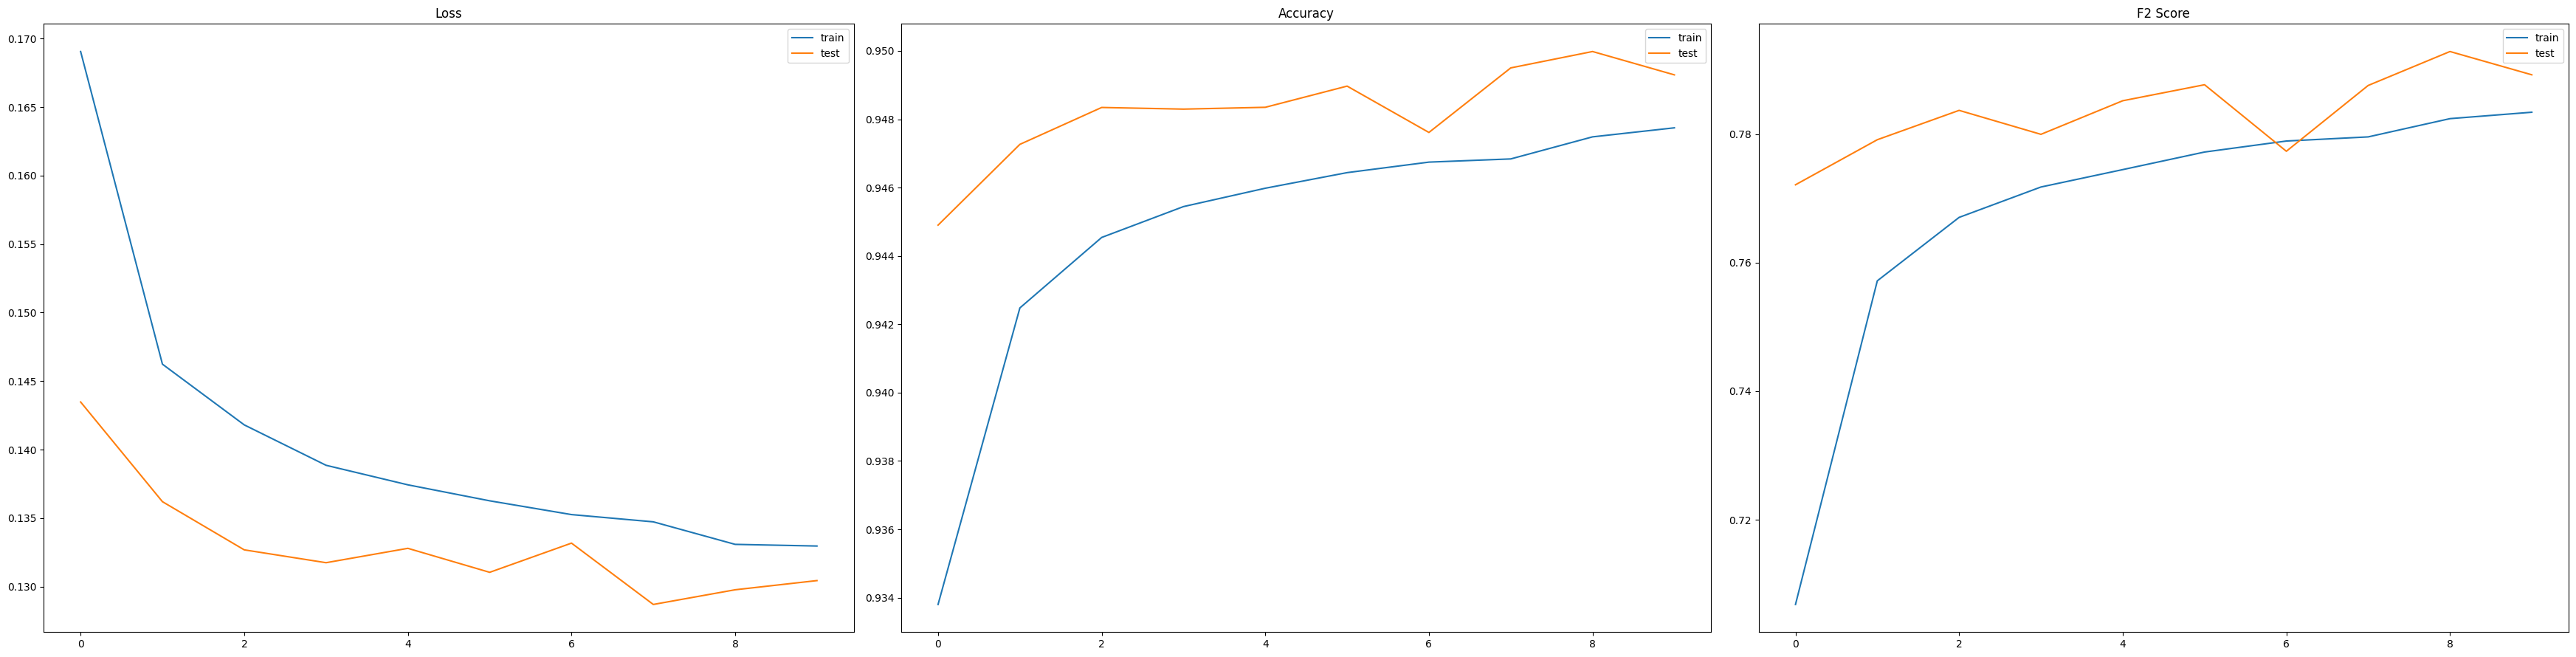

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(35, 9))

# Loss plot
loss_array = zip(train_loss_array, test_loss_array)
loss_df = pd.DataFrame(loss_array, columns=['train', 'test'])
loss_df.plot(ax=axes[0])
axes[0].set_title('Loss')

# Correct plot
correct_array = zip(train_correct_array, test_correct_array)
correct_df = pd.DataFrame(correct_array, columns=['train', 'test'])
correct_df.plot(ax=axes[1])
axes[1].set_title('Accuracy')

# F2 plot
f2_array = zip(train_f2_array, test_f2_array)
f2_df = pd.DataFrame(f2_array, columns=['train', 'test'])
f2_df.plot(ax=axes[2])
axes[2].set_title('F2 Score')

plt.tight_layout()
plt.savefig("line_chart.png", format='png')
plt.show()

In [28]:
print('Minimal test loss:' + str(np.min(test_loss_array)))
print('Maximum test F2_score:' + str(np.max(test_f2_array)))
print('Maximum test accuracy:' + str(np.max(test_correct_array)))

Minimal test loss:0.12869670232500247
Maximum test F2_score:0.7928300969921082
Maximum test accuracy:0.9499825988362429


**Confusion matrix**

A confusion matrix was applied on the test set result to see the accuracy in each label and to identify the labels that are similar and were missclassified.

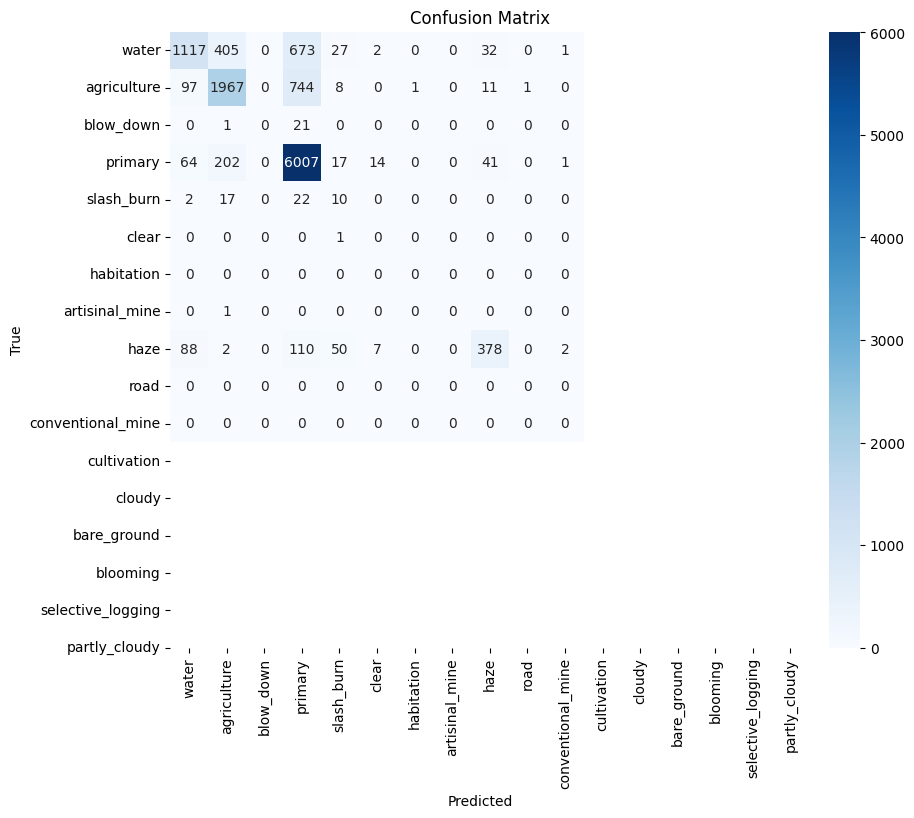

In [29]:
from sklearn.metrics import confusion_matrix
#For this matrix, I used Gemini AI with the prompt "how to create a confusion matrix with torch?"
y_true = []
y_pred = []

with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = model_ft(X)
        predicted_labels = (torch.sigmoid(pred) > 0.5).int()
        y_true.extend(y.cpu().numpy())
        y_pred.extend(predicted_labels.cpu().numpy())

# Convert list of tensors to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# multi-label format to class indices
y_true_labels = y_true.argmax(axis=1)
y_pred_labels = y_pred.argmax(axis=1)

# Get class names from inv_label_map
class_names = [inv_label_map[i] for i in sorted(inv_label_map)]

# Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.svg", format='svg')
plt.show()

**Misclassified images**

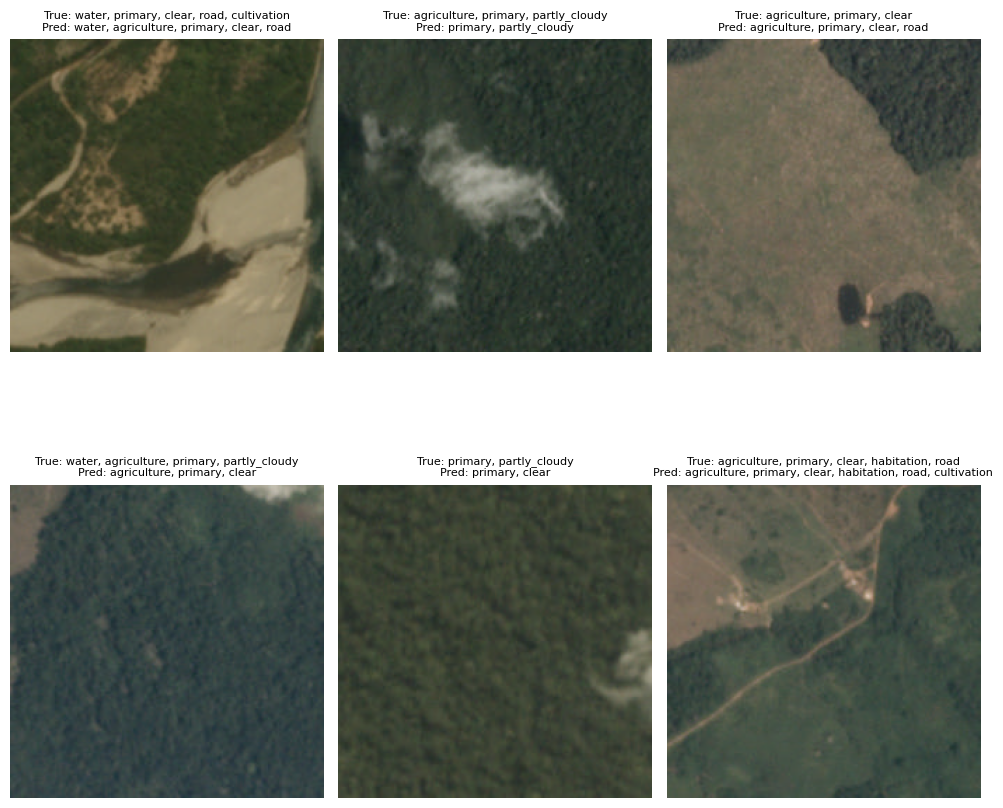

In [30]:
#I adapted the code above to extract random images and I used Gemini AI to know how to extract those that contain misclassified labels
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

# model predictions
with torch.no_grad():
  pred = model_ft(images)
  predicted_labels = (torch.sigmoid(pred) > 0.5).int()

# find images with incorrect predictions
incorrect_indices = []
for i in range(len(labels)):
    if not torch.equal(labels[i], predicted_labels[i]):
        incorrect_indices.append(i)

incorrect_indices = incorrect_indices[:6] # sample of 9 images

# get the images and labels
incorrect_images = images[incorrect_indices]
incorrect_labels = labels[incorrect_indices]
incorrect_predicted_labels = predicted_labels[incorrect_indices]

# labels display
inv_images = inv_normalize(incorrect_images.cpu())
batch_word_labels = []
batch_word_predicted_labels = []
for label_tensor, predicted_label_tensor in zip(incorrect_labels, incorrect_predicted_labels):
    # True labels
    indices = (label_tensor.cpu() == 1).nonzero(as_tuple=True)[0]
    tags = [inv_label_map[i.item()] for i in indices]
    batch_word_labels.append(", ".join(tags))
    # Predicted labels
    indices = (predicted_label_tensor.cpu() == 1).nonzero(as_tuple=True)[0]
    tags = [inv_label_map[i.item()] for i in indices]
    batch_word_predicted_labels.append(", ".join(tags))

# plot
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = inv_images[i].numpy()
    img = np.transpose(img, (1, 2, 0))
    ax.imshow(img)
    ax.set_title(f"True: {batch_word_labels[i]}\nPred: {batch_word_predicted_labels[i]}", fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.savefig('incorrect_predictions.png')
plt.show()

**Vaupes region**

I want to test the model with a sample of image extracted from the Sentinel-2 satellite.
https://browser.dataspace.copernicus.eu/?zoom=5&lat=50.16282&lng=20.78613&themeId=DEFAULT-THEME&demSource3D=%22MAPZEN%22&cloudCoverage=30&dateMode=SINGLE

The image corresponds to Vaupes, an amazonic state in Colombia. The image is from january 21 of 2025 and covers a great part of the state. First I cropped the image to several batches of 256x256 px as used in the model.


In [32]:
import cv2
from torchvision.transforms import functional as F

#image loading
image = cv2.imread('Vaupes.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Pixels
patch_size = 256
stride = 256

# Image dimensions
height, width, _ = image.shape

# For this, I use Gemini AI to learn how to crop my image in squares of 256x256 px
patches = []
coords = []  # to keep track of patch positions if needed

for y in range(0, height - patch_size + 1, stride):
    for x in range(0, width - patch_size + 1, stride):
        patch = image[y:y+patch_size, x:x+patch_size]
        patch_tensor = transforms.ToTensor()(patch)
        patch_tensor = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(patch_tensor)
        patches.append(patch_tensor)
        coords.append((x, y))

# Stack patches into a batch
patches = torch.stack(patches)

print(f"Number of patches: {patches.shape[0]}")

Number of patches: 3920


In [33]:
outputs = [] #list to save the results
batch_size = 128  # to reduce memory

for i in range(0, patches.shape[0], batch_size):
    batch = patches[i:i + batch_size].to(device)
    with torch.no_grad():
        batch_outputs = model_ft(batch)
    outputs.append(batch_outputs.cpu())
outputs = torch.cat(outputs)

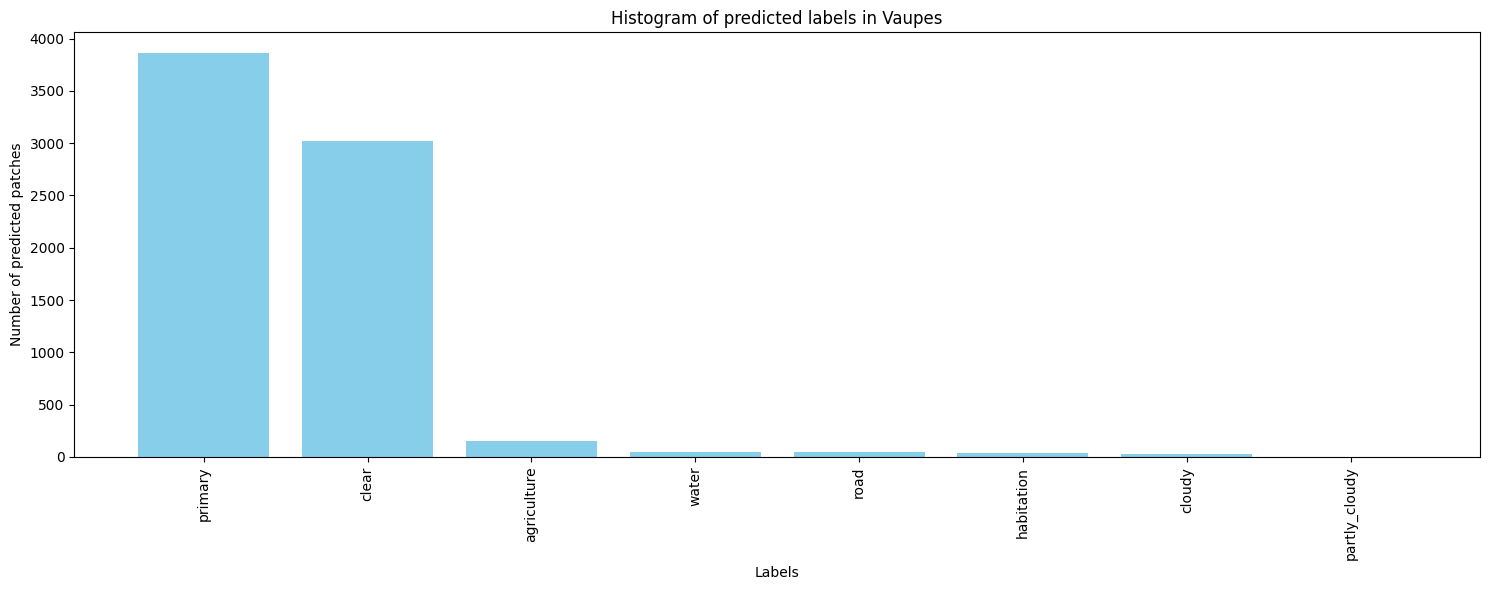

In [35]:
# Applying the threshold to convert probabilities into binary predictions
predictions = (outputs > 0.5).int()
label_counts_pred = {}

# Iterate each patch's predicted labels
for labels in predictions:
    for i in range(len(labels)):
        if labels[i] == 1:
            label_name = inv_label_map[i]  # Use your existing label mapping
            label_counts_pred[label_name] = label_counts_pred.get(label_name, 0) + 1

# Sorting counts from highest to lowest
sorted_label_counts_pred = dict(sorted(label_counts_pred.items(), key=lambda item: item[1], reverse=True))

# Histogram plot of labels frequencies in the zone
plt.figure(figsize=(15, 6))
plt.bar(sorted_label_counts_pred.keys(), sorted_label_counts_pred.values(), color='skyblue')
plt.xticks(rotation=90)
plt.xlabel("Labels")
plt.ylabel("Number of predicted patches")
plt.title("Histogram of predicted labels in Vaupes")
plt.tight_layout()
plt.savefig('Vaupes_histogram.png')
plt.show()

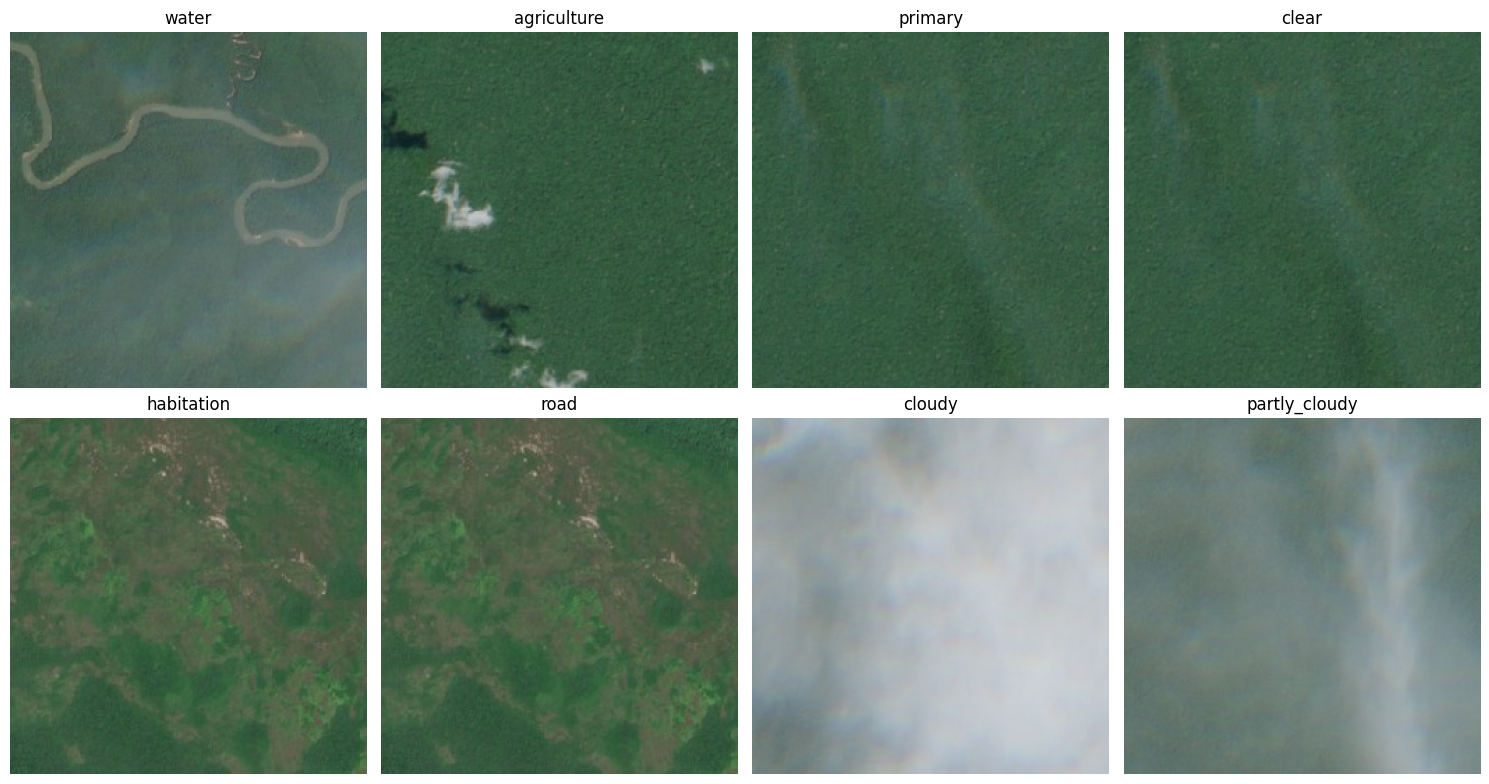

In [37]:
# Dictionary to hold one example per label to do a random visual inspection
sample_patches = {}

for idx_label in range(predictions.shape[1]):
    label_name = inv_label_map[idx_label]
    for idx_patch in range(predictions.shape[0]):
        if predictions[idx_patch][idx_label] == 1:
            if label_name not in sample_patches:
                sample_patches[label_name] = patches[idx_patch]
                break

# Plot
n_cols = 4
n_rows = (len(sample_patches) + n_cols - 1) // n_cols  # Auto adjust number of rows
plt.figure(figsize=(15, n_rows * 4))

for idx, (label, patch) in enumerate(sample_patches.items()):
    plt.subplot(n_rows, n_cols, idx + 1)
    patch_vis = patch.clone()
    patch_vis = patch_vis * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    patch_vis = torch.clamp(patch_vis, 0, 1)

    plt.imshow(patch_vis.permute(1, 2, 0).cpu().numpy())
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.savefig('Vaupes_sample.png')
plt.show()